In [1]:
import numpy as np
from sigvisa import Sigvisa

from sigvisa.infer.coarse_to_fine_init import ModelSpec, EventRunSpec, TimeRangeRunSpec, do_coarse_to_fine, initialize_from, do_inference, initialize_sg
from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.treegp.gp import GPCov
from sigvisa.graph.region import Region

import cPickle as pickle

from sigvisa.utils.geog import dist_km

%matplotlib inline
import matplotlib.pylab as plt

from sigvisa.signals.common import Waveform
from sigvisa.signals.io import load_event_station_chan, fetch_waveform

from sigvisa.source.event import get_event
from sigvisa.models.ttime import tt_predict

from sigvisa.infer.template_xc import fastxc
from sigvisa.infer.correlations.ar_correlation_model import iid_advantage

# Correlations against the Wells main shock

405
918


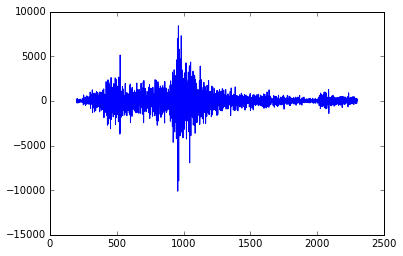

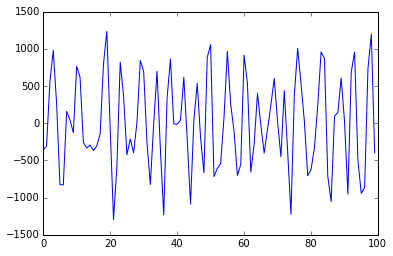

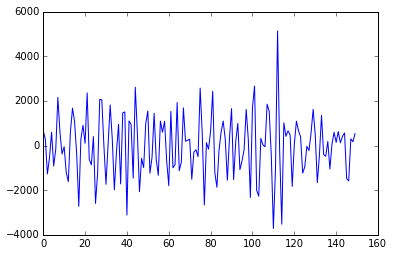

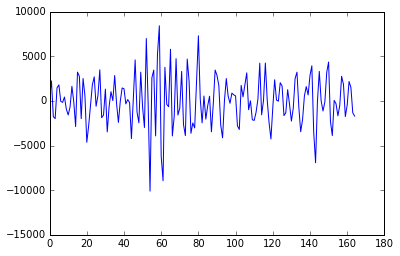

In [2]:
#wells_ev = get_event(3375224) 


wells_ev = get_event(3375230) 

wells_atime = wells_ev.time + tt_predict(wells_ev, "NV01", "Pn")
wells_Pg_atime = wells_ev.time + tt_predict(wells_ev, "NV01", "Pg")
wells_Lg_atime = wells_ev.time + tt_predict(wells_ev, "NV01", "Lg")


wells_wave = fetch_waveform("NV01", chan="auto", 
                            stime=wells_atime-10.0, 
                            etime=wells_atime+200,
                            pad_seconds=20.0).filter("freq_0.8_4.5;hz_10.0")

plt.plot(wells_wave.data)

plt.figure()
pn_data = wells_wave.data[300:400]
plt.plot(pn_data)

plt.figure()
pg_idx = int(wells_wave["srate"] * (wells_Pg_atime - wells_wave["stime"]))
print pg_idx
pg_data = wells_wave.data[pg_idx +10 : pg_idx + 160]
plt.plot(pg_data)

plt.figure()
lg_idx = int(wells_wave["srate"] * (wells_Lg_atime - wells_wave["stime"]))
print lg_idx
lg_data = wells_wave.data[lg_idx -15 : lg_idx + 150]
plt.plot(lg_data)

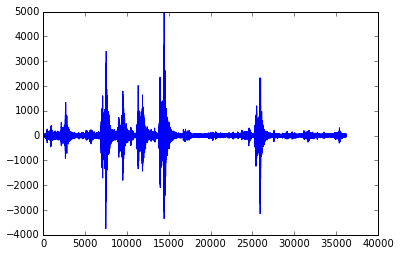

In [3]:
stime = 1203624962 
etime = 1203628562

validation_wave = fetch_waveform("NV01", chan="auto", stime=stime, etime=etime).filter("freq_0.8_4.5;hz_10.0")
plt.plot(validation_wave.data)


3


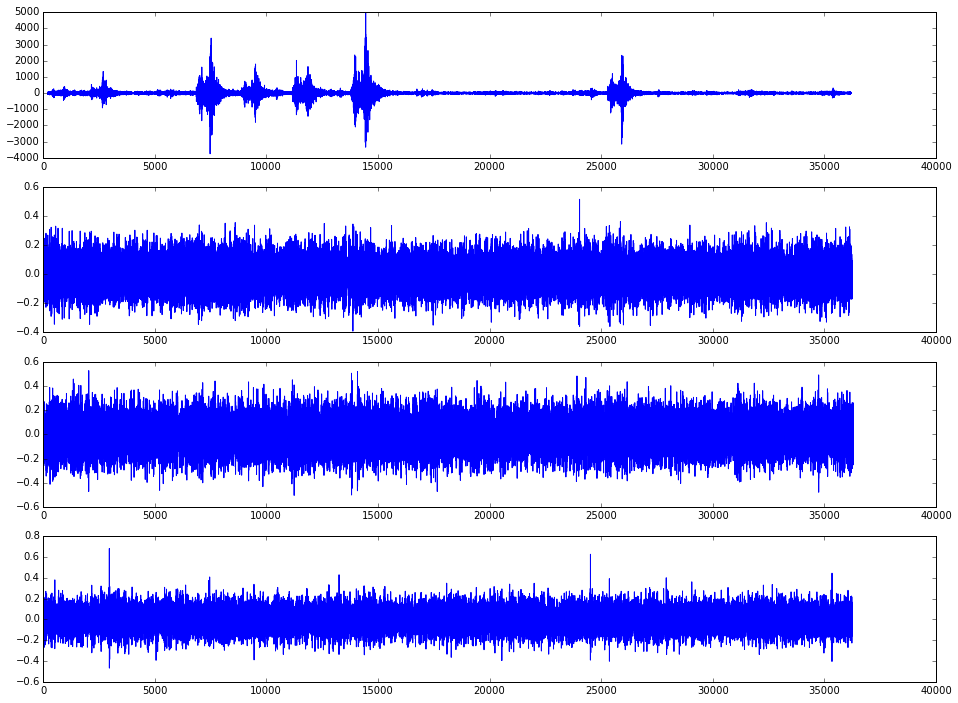

In [4]:
def plot_correlations(long_wave, *short_waves):
    n = len(short_waves)
    print n

    f = plt.figure(figsize=(16, 3 * (n+1)))

    ax = f.add_subplot(n+1, 1, 1)
    ax.plot(long_wave)
    
    for i in range(n):
        ax = f.add_subplot(n+1, 1, i+2)
        xc = fastxc(short_waves[i], long_wave)
        #xc = iid_advantage(long_wave, short_waves[i])
        ax.plot(xc)

plot_correlations(validation_wave.data, pg_data, pn_data, lg_data)

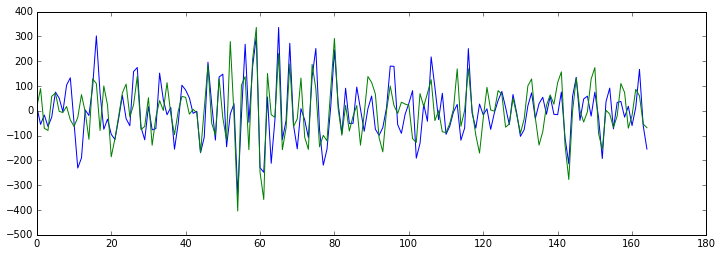

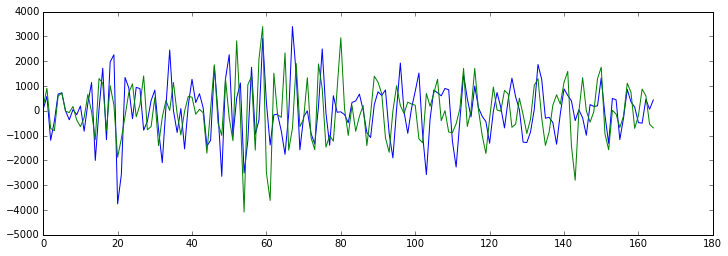

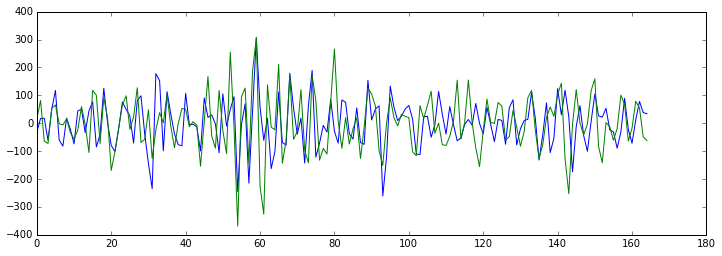

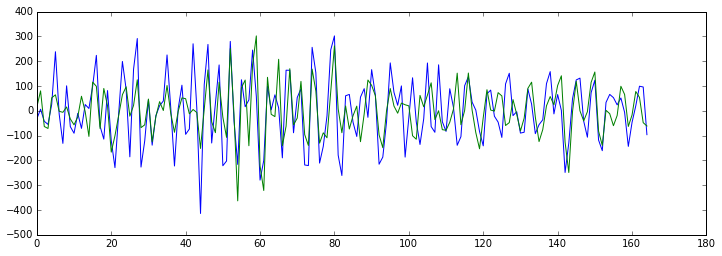

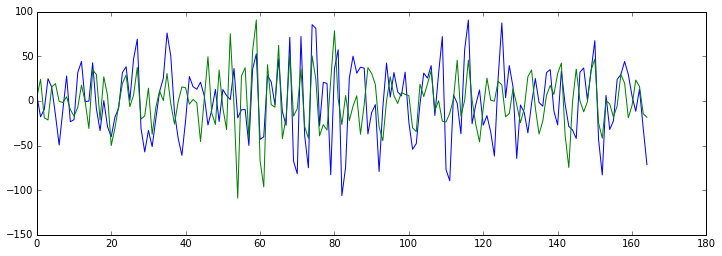

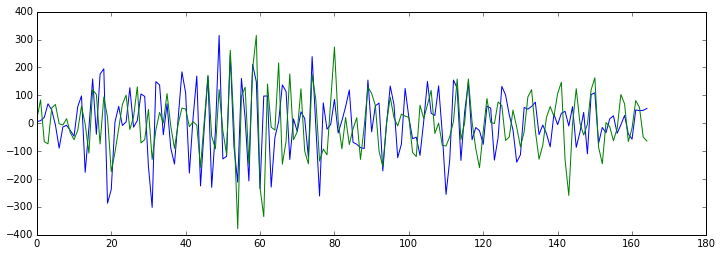

In [5]:
def plot_potential_correlations(long_signal, short_signal, xc_threshold=0.4):
    xc = fastxc(short_signal, long_signal)
    idx_matches = np.arange(len(xc))[xc > xc_threshold]
    
    
    for idx in idx_matches:
        plt.figure(figsize=(12, 4))
        excerpt = long_signal[idx: idx + len(short_signal)]
        ss = short_signal * np.max(excerpt) / np.max(short_signal)
        plt.plot(excerpt)
        plt.plot(ss)
        
plot_potential_correlations(validation_wave.data, lg_data)